In [4]:
import gdsfactory as gf
import numpy as np
import matplotlib.pyplot as plt


In [1]:
from gds_helpers import Edge, Polygon
from gds_helpers import extract_edges_from_polygons, connect_polygons, get_polygon_family, combine_polygons
from gds_helpers import create_gds_from_polygons

In [5]:
file_path = 'RD0605.01_Exposed.gds'
gds = gf.read.import_gds(file_path)
print(type(gds))
gds_polygons = gds.get_polygons_points()
print(gds_polygons.keys())
for k in gds_polygons.keys():
    print(f'layer:{k}, polygon number: {len(gds_polygons[k])}')

<class 'gdsfactory.component.Component'>
dict_keys([1, 3, 8, 45, 46, 47])
layer:1, polygon number: 23615
layer:3, polygon number: 715274
layer:8, polygon number: 14027
layer:45, polygon number: 57844
layer:46, polygon number: 2
layer:47, polygon number: 32


In [6]:
output_vertices = []
for k in gds_polygons.keys():
    print(f'Processing layer {k}...')
    polygons = gds_polygons[k]
    edges, all_points, edge_map, polygon_list = extract_edges_from_polygons(polygons)
    connected_polygon_list = connect_polygons(edges, all_points, polygon_list)
    polygon_family_list = get_polygon_family(connected_polygon_list)
    combined_polygon_list = combine_polygons(polygon_family_list)    
    for p in combined_polygon_list:
        # print(type(p))
        vertices = p.get_vertices()
        output_vertices.append(vertices)

create_gds_from_polygons(output_vertices, 'RD0605.01_Combined_Python.gds')

Processing layer 1...
Starting edge extraction from polygons...
Extracting edges from polygon 23615/23615...
Edge extraction completed. Total edges extracted: 94488
Time taken for edge extraction: 1.03 seconds
Building KD-Tree with edge midpoints...
KD-Tree built successfully.
Detecting shared edges and merging polygons...
Polygon connection discovery completed. Total connected polygons found: 0
Time taken for polygon combination: 6.03 seconds
Finished collecting polygon families. Total polygon families found: 23615

Finished combining all polygon families.
Processing layer 3...
Starting edge extraction from polygons...
Extracting edges from polygon 715274/715274...
Edge extraction completed. Total edges extracted: 3026229
Time taken for edge extraction: 65.28 seconds
Building KD-Tree with edge midpoints...
KD-Tree built successfully.
Detecting shared edges and merging polygons...
Polygon connection discovery completed. Total connected polygons found: 629015
Time taken for polygon comb

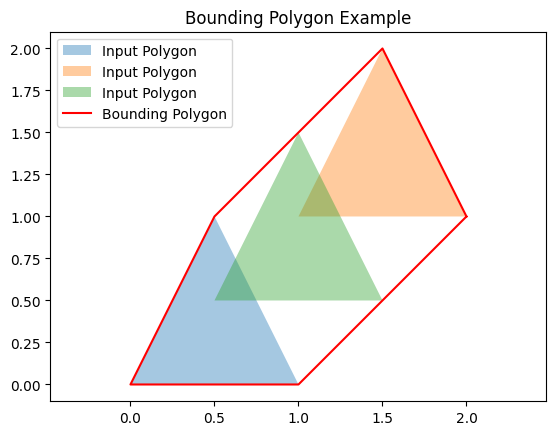

In [7]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def create_bounding_polygon(polygons):
    """
    Create a bounding polygon that encloses all given polygons.
    
    Parameters:
        polygons (list of np.ndarray): List of n x 2 arrays, each representing a polygon's vertices.
        
    Returns:
        np.ndarray: Vertices of the bounding polygon in counter-clockwise order.
    """
    # Combine all vertices into a single array
    all_points = np.vstack(polygons)
    
    # Compute the convex hull
    hull = ConvexHull(all_points)
    
    # Return the vertices of the convex hull in counter-clockwise order
    bounding_polygon = all_points[hull.vertices]
    return bounding_polygon

# Example usage
if __name__ == "__main__":
    # Define example polygons
    polygon1 = np.array([[0, 0], [1, 0], [0.5, 1]])
    polygon2 = np.array([[1, 1], [2, 1], [1.5, 2]])
    polygon3 = np.array([[0.5, 0.5], [1.5, 0.5], [1, 1.5]])
    
    polygons = [polygon1, polygon2, polygon3]
    
    # Create the bounding polygon
    bounding_polygon = create_bounding_polygon(polygons)
    
    # Plot the results
    plt.figure()
    for polygon in polygons:
        plt.fill(polygon[:, 0], polygon[:, 1], alpha=0.4, label="Input Polygon")
    plt.plot(*np.vstack([bounding_polygon, bounding_polygon[0]]).T, 'r-', label="Bounding Polygon")
    plt.legend()
    plt.axis('equal')
    plt.title("Bounding Polygon Example")
    plt.show()


In [11]:
def get_combined_polygons(polygons):
    edges, all_points, edge_map, polygon_list = extract_edges_from_polygons(polygons)
    connected_polygon_list = connect_polygons(edges, all_points, polygon_list)
    polygon_family_list = get_polygon_family(connected_polygon_list)
    combined_polygon_list = combine_polygons(polygon_family_list) 
    return combined_polygon_list

In [12]:
epe_polygons = gds_polygons[3]
ic_polygons = gds_polygons[8]
oc_polygons = gds_polygons[1]

epe_combined_polygons = get_combined_polygons(epe_polygons)
ic_combined_polygons = get_combined_polygons(ic_polygons)
oc_combined_polygons = get_combined_polygons(oc_polygons)


Starting edge extraction from polygons...
Extracting edges from polygon 715274/715274...
Edge extraction completed. Total edges extracted: 3026229
Time taken for edge extraction: 63.56 seconds
Building KD-Tree with edge midpoints...
KD-Tree built successfully.
Detecting shared edges and merging polygons...
Polygon connection discovery completed. Total connected polygons found: 629015
Time taken for polygon combination: 229.22 seconds
Finished collecting polygon families. Total polygon families found: 86266
Combining polygon families: 81001/86266 completed
Finished combining all polygon families.
Starting edge extraction from polygons...
Extracting edges from polygon 14027/14027...
Edge extraction completed. Total edges extracted: 56365
Time taken for edge extraction: 0.78 seconds
Building KD-Tree with edge midpoints...
KD-Tree built successfully.
Detecting shared edges and merging polygons...
Polygon connection discovery completed. Total connected polygons found: 6557
Time taken for po

In [33]:
def get_combined_vertices(polygon_list):    
    p_combined_vertices = polygon_list.pop(0).get_vertices()
    polygon_num = len(polygon_list)
    total_vertices_num = p_combined_vertices.shape[0]
    for i, p in enumerate(polygon_list):
        if i % 1000 == 0:
            print(f'\rCombining polygon number {i} / {polygon_num}...', end='', flush=True)
        total_vertices_num += (p.get_vertices().shape[0])
        combined_vertices = np.vstack([p_combined_vertices, p.get_vertices()])
        p_combined_vertices = create_bounding_polygon(combined_vertices)
    print(f'\nFinished polygon combination of {total_vertices_num}, and output bounding polygon with {p_combined_vertices.shape[0]}')
    return p_combined_vertices

In [36]:
ic_bounding_polygon = get_combined_vertices(ic_combined_polygons)
oc_bounding_polygon = get_combined_vertices(oc_combined_polygons)

Combining polygon number 7000 / 7469...
Finished polygon combination of 50721, and output bounding polygon with 7492
Combining polygon number 23000 / 23614...
Finished polygon combination of 118103, and output bounding polygon with 12
